a_r = 1.5
b_r = 0.8999999999999999
GEN: 32→128→256→128→1
DISC: 1→128→256→128→1


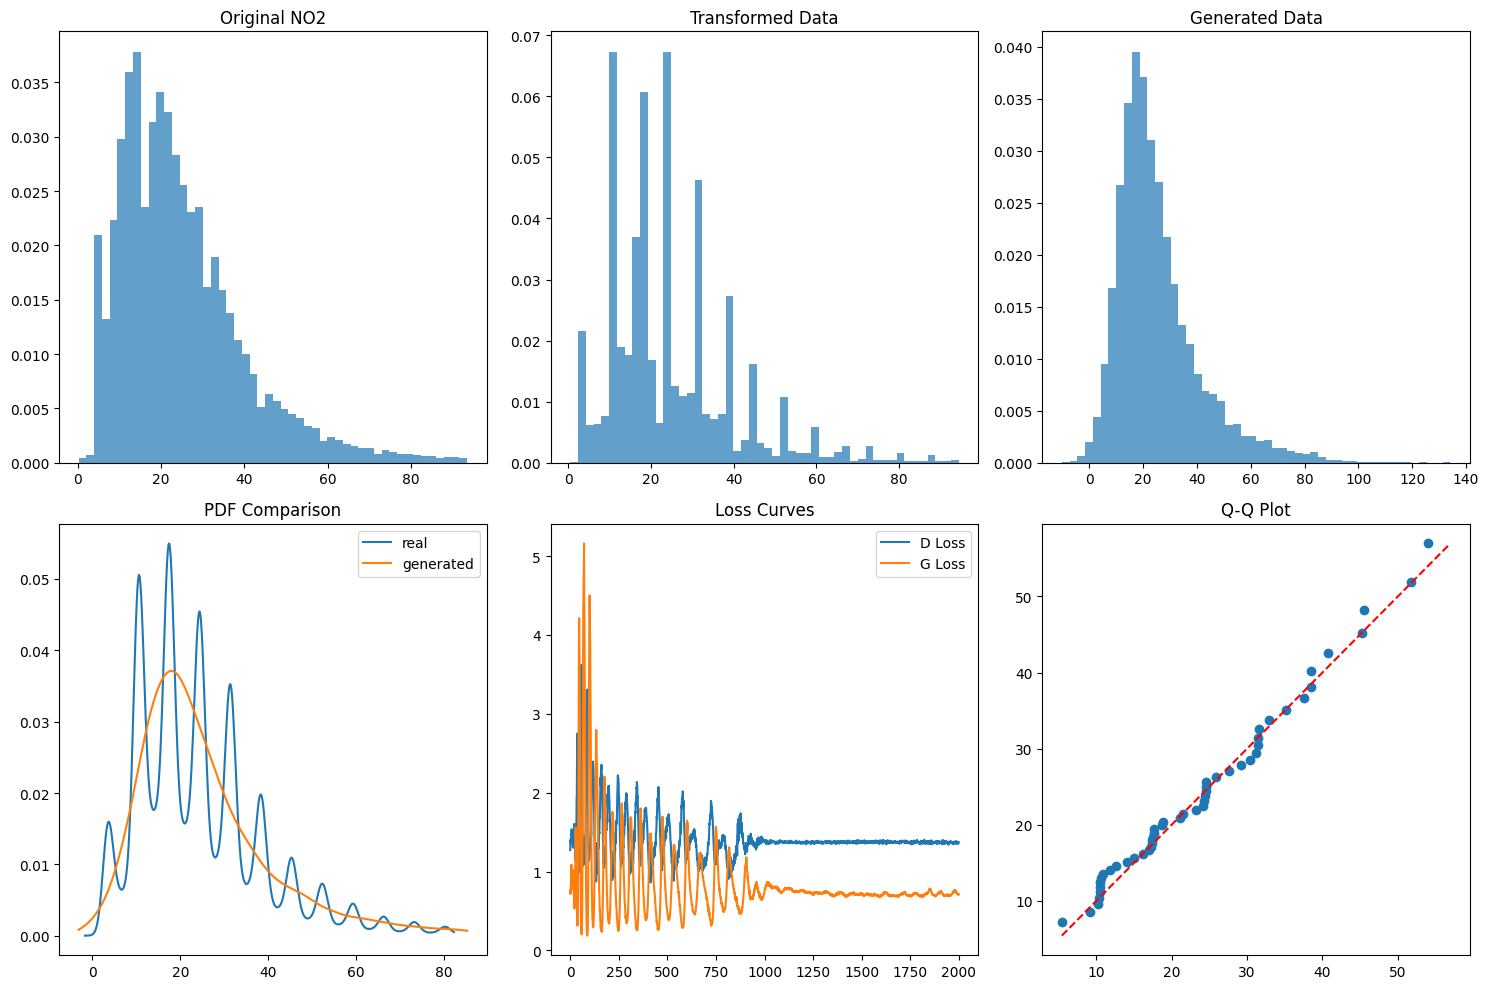

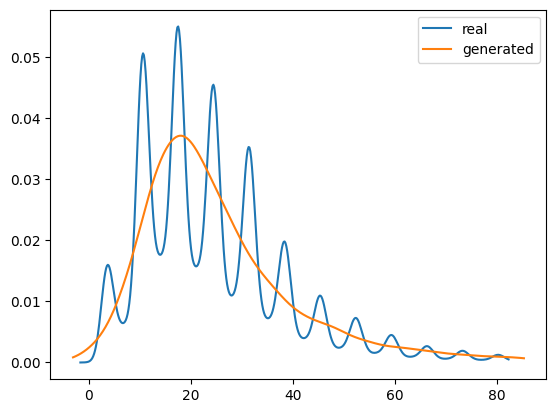

Mode coverage: good
Quality: good
KS: 0.0871855741975949
Wasserstein: 1.2195517976976697


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

ROLL_NUMBER = 102303862
a_r = 0.5 * (ROLL_NUMBER % 7)
b_r = 0.3 * (ROLL_NUMBER % 5 + 1)

def load_no2_data(filepath='/content/data[1].csv'):
    df = pd.read_csv(filepath, encoding='latin1')
    x = df["no2"].dropna().values
    x = x[x > 0]
    x = x[x < np.percentile(x, 99)]
    return x

def transform_data(x, a_r, b_r):
    return x + a_r * np.sin(b_r * x)

class GAN:
    def __init__(self, latent_dim=32, g_hidden=[128,256,128], d_hidden=[128,256,128]):
        self.latent_dim = latent_dim
        self.g_hidden = g_hidden
        self.d_hidden = d_hidden
        self._init_generator()
        self._init_discriminator()
        self.d_losses = []
        self.g_losses = []
        self.data_mean = 0
        self.data_std = 1
        self.t = 0

    def _init_generator(self):
        self.g_weights=[]; self.g_biases=[]
        self.g_adam_m_w=[]; self.g_adam_v_w=[]
        self.g_adam_m_b=[]; self.g_adam_v_b=[]
        dims=[self.latent_dim]+self.g_hidden+[1]
        for i in range(len(dims)-1):
            s=np.sqrt(2.0/dims[i])
            self.g_weights.append(np.random.randn(dims[i],dims[i+1])*s)
            self.g_biases.append(np.zeros(dims[i+1]))
            self.g_adam_m_w.append(np.zeros((dims[i],dims[i+1])))
            self.g_adam_v_w.append(np.zeros((dims[i],dims[i+1])))
            self.g_adam_m_b.append(np.zeros(dims[i+1]))
            self.g_adam_v_b.append(np.zeros(dims[i+1]))

    def _init_discriminator(self):
        self.d_weights=[]; self.d_biases=[]
        self.d_adam_m_w=[]; self.d_adam_v_w=[]
        self.d_adam_m_b=[]; self.d_adam_v_b=[]
        dims=[1]+self.d_hidden+[1]
        for i in range(len(dims)-1):
            s=np.sqrt(2.0/dims[i])
            self.d_weights.append(np.random.randn(dims[i],dims[i+1])*s)
            self.d_biases.append(np.zeros(dims[i+1]))
            self.d_adam_m_w.append(np.zeros((dims[i],dims[i+1])))
            self.d_adam_v_w.append(np.zeros((dims[i],dims[i+1])))
            self.d_adam_m_b.append(np.zeros(dims[i+1]))
            self.d_adam_v_b.append(np.zeros(dims[i+1]))

    @staticmethod
    def leaky_relu(x,a=0.2):
        return np.where(x>0,x,a*x)

    @staticmethod
    def leaky_relu_derivative(x,a=0.2):
        return np.where(x>0,1.0,a)

    @staticmethod
    def sigmoid(x):
        x=np.clip(x,-500,500)
        return 1/(1+np.exp(-x))

    def generator_forward(self,noise):
        self.g_pre=[]; self.g_act=[noise]
        x=noise
        for i in range(len(self.g_weights)-1):
            z=x@self.g_weights[i]+self.g_biases[i]
            self.g_pre.append(z)
            x=self.leaky_relu(z)
            self.g_act.append(x)
        z=x@self.g_weights[-1]+self.g_biases[-1]
        self.g_pre.append(z); self.g_act.append(z)
        return z

    def discriminator_forward(self,x):
        self.d_pre=[]; self.d_act=[x.reshape(-1,1)]
        h=x.reshape(-1,1)
        for i in range(len(self.d_weights)-1):
            z=h@self.d_weights[i]+self.d_biases[i]
            self.d_pre.append(z)
            h=self.leaky_relu(z)
            self.d_act.append(h)
        z=h@self.d_weights[-1]+self.d_biases[-1]
        self.d_pre.append(z)
        out=self.sigmoid(z)
        self.d_act.append(out)
        return out

    def _adam_update(self,p,g,m,v,lr,b1=0.9,b2=0.999,eps=1e-8):
        m=b1*m+(1-b1)*g
        v=b2*v+(1-b2)*(g**2)
        m_hat=m/(1-b1**self.t)
        v_hat=v/(1-b2**self.t)
        p-=lr*m_hat/(np.sqrt(v_hat)+eps)
        return m,v

    def train_discriminator(self,real,fake,lr):
        b=len(real); eps=1e-8
        rp=self.discriminator_forward(real)
        ra=[a.copy() for a in self.d_act]
        rp_pre=[p.copy() for p in self.d_pre]
        fp=self.discriminator_forward(fake)
        fa=[a.copy() for a in self.d_act]
        fp_pre=[p.copy() for p in self.d_pre]
        d_loss=-np.mean(np.log(rp+eps))-np.mean(np.log(1-fp+eps))
        dr=(rp-1)/b; gw_r=[]; gb_r=[]
        for i in range(len(self.d_weights)-1,-1,-1):
            gw_r.insert(0,ra[i].T@dr); gb_r.insert(0,np.sum(dr,axis=0))
            if i>0: dr=(dr@self.d_weights[i].T)*self.leaky_relu_derivative(rp_pre[i-1])
        df=fp/b; gw_f=[]; gb_f=[]
        for i in range(len(self.d_weights)-1,-1,-1):
            gw_f.insert(0,fa[i].T@df); gb_f.insert(0,np.sum(df,axis=0))
            if i>0: df=(df@self.d_weights[i].T)*self.leaky_relu_derivative(fp_pre[i-1])
        for i in range(len(self.d_weights)):
            tg=np.clip(gw_r[i]+gw_f[i],-1,1)
            tb=np.clip(gb_r[i]+gb_f[i],-1,1)
            self.d_adam_m_w[i],self.d_adam_v_w[i]=self._adam_update(self.d_weights[i],tg,self.d_adam_m_w[i],self.d_adam_v_w[i],lr)
            self.d_adam_m_b[i],self.d_adam_v_b[i]=self._adam_update(self.d_biases[i],tb,self.d_adam_m_b[i],self.d_adam_v_b[i],lr)
        return d_loss

    def train_generator(self,batch,lr):
        eps=1e-8
        noise=np.random.randn(batch,self.latent_dim)
        fake=self.generator_forward(noise)
        fp=self.discriminator_forward(fake.flatten())
        g_loss=-np.mean(np.log(fp+eps))
        d=(fp-1)/batch
        for i in range(len(self.d_weights)-1,0,-1):
            d=(d@self.d_weights[i].T)*self.leaky_relu_derivative(self.d_pre[i-1])
        d_out=d@self.d_weights[0].T
        gw=[]; gb=[]
        delta=d_out
        for i in range(len(self.g_weights)-1,-1,-1):
            gw.insert(0,self.g_act[i].T@delta)
            gb.insert(0,np.sum(delta,axis=0))
            if i>0:
                delta=(delta@self.g_weights[i].T)*self.leaky_relu_derivative(self.g_pre[i-1])
        for i in range(len(self.g_weights)):
            tw=np.clip(gw[i],-1,1)
            tb=np.clip(gb[i],-1,1)
            self.g_adam_m_w[i],self.g_adam_v_w[i]=self._adam_update(self.g_weights[i],tw,self.g_adam_m_w[i],self.g_adam_v_w[i],lr)
            self.g_adam_m_b[i],self.g_adam_v_b[i]=self._adam_update(self.g_biases[i],tb,self.g_adam_m_b[i],self.g_adam_v_b[i],lr)
        return g_loss

    def train(self,data,epochs=2000,batch=128,d_lr=0.0002,g_lr=0.0002):
        self.data_mean=np.mean(data)
        self.data_std=np.std(data)
        nd=(data-self.data_mean)/(self.data_std+1e-8)
        n=len(nd)
        for e in range(epochs):
            self.t+=1
            idx=np.random.randint(0,n,batch)
            real=nd[idx]
            noise=np.random.randn(batch,self.latent_dim)
            fake=self.generator_forward(noise).flatten()
            d=self.train_discriminator(real,fake,d_lr)
            g=self.train_generator(batch,g_lr)
            self.d_losses.append(d); self.g_losses.append(g)

    def generate(self,n):
        noise=np.random.randn(n,self.latent_dim)
        s=self.generator_forward(noise).flatten()
        return s*(self.data_std+1e-8)+self.data_mean

def estimate_pdf(s):
    xmin=np.percentile(s,1)-5
    xmax=np.percentile(s,99)+5
    xv=np.linspace(xmin,xmax,500)
    kde=stats.gaussian_kde(s,bw_method='scott')
    pdf=kde(xv)
    return xv,pdf

def evaluate(z,g):
    w=stats.wasserstein_distance(z,g)
    ks=stats.ks_2samp(z,g)[0]
    mc="good" if abs(np.mean(z)-np.mean(g))<5 else "moderate"
    qt="good" if w<7 else "moderate"
    return mc,qt,ks,w

def main():
    print("a_r =",a_r)
    print("b_r =",b_r)
    print("GEN: 32→128→256→128→1")
    print("DISC: 1→128→256→128→1")
    x=load_no2_data('/content/data[1].csv')
    z=transform_data(x,a_r,b_r)
    gan=GAN()
    gan.train(z)
    g=gan.generate(10000)
    plt.figure(figsize=(15,10))

    plt.subplot(2,3,1)
    plt.hist(x, bins=50, density=True, alpha=0.7)
    plt.title("Original NO2")

    plt.subplot(2,3,2)
    plt.hist(z, bins=50, density=True, alpha=0.7)
    plt.title("Transformed Data")

    plt.subplot(2,3,3)
    plt.hist(g, bins=50, density=True, alpha=0.7)
    plt.title("Generated Data")

    xv1,p1=estimate_pdf(z)
    xv2,p2=estimate_pdf(g)
    plt.subplot(2,3,4)
    plt.plot(xv1,p1,label="real")
    plt.plot(xv2,p2,label="generated")
    plt.title("PDF Comparison")
    plt.legend()

    plt.subplot(2,3,5)
    plt.plot(gan.d_losses,label="D Loss")
    plt.plot(gan.g_losses,label="G Loss")
    plt.title("Loss Curves")
    plt.legend()

    plt.subplot(2,3,6)
    percentiles = np.linspace(5,95,50)
    real_q = np.percentile(z, percentiles)
    gen_q = np.percentile(g, percentiles)
    plt.scatter(real_q, gen_q)
    mn, mx = min(real_q.min(), gen_q.min()), max(real_q.max(), gen_q.max())
    plt.plot([mn,mx],[mn,mx],'r--')
    plt.title("Q-Q Plot")

    plt.tight_layout()
    plt.show()

    xv1,p1=estimate_pdf(z)
    xv2,p2=estimate_pdf(g)
    plt.plot(xv1,p1,label="real")
    plt.plot(xv2,p2,label="generated")
    plt.legend()
    plt.savefig("pdf.png",dpi=150)
    plt.show()
    mc,qt,ks,w=evaluate(z,g)
    print("Mode coverage:",mc)
    print("Quality:",qt)
    print("KS:",ks)
    print("Wasserstein:",w)

main()
